# Inference of hierarchical bimodal problem parameters

In [1]:
import arviz as az
import chi
import matplotlib.pyplot as plt
import numpy as np
import pints
import scipy.stats
import seaborn as sns
import xarray as xr
sns.set_theme()

The data-generating distribution is
$$
    y \sim p(\cdot | \mu _{\mathrm{pop}}, \mu _{\lambda},  \sigma _{\mu}, \sigma _{\lambda}, t)=
    \int \mathrm{d}\mu \, \mathrm{d}\lambda \,
    \frac{1}{2}\left(
        \mathcal{N}(y | \mu t, 0.1)\,
        \mathcal{N}(\mu | \mu _{\mu}, \sigma ^2 _{\mu}) +
        \mathcal{N}(y | \mathrm{e}^{\lambda t}, 0.1)\,
        \mathcal{N}(\lambda | \mu _{\lambda}, \sigma ^2 _{\lambda})
    \right)
$$

# Synthesise data

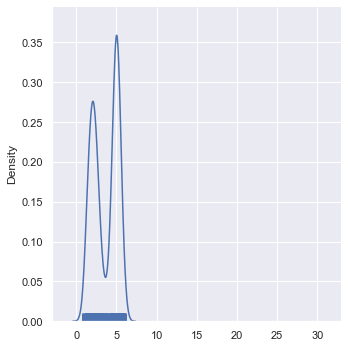

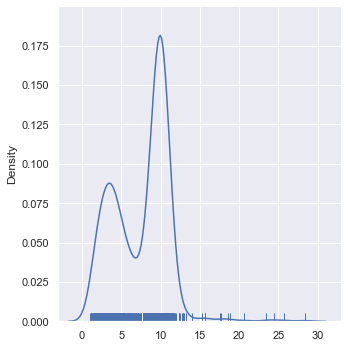

In [117]:
np.random.seed(42)
n_ids = 1000
true_parameters = [10, 1.5, 0.8, 0.6, 0.1]  # mu_mu, mu_nu, sigma_mu, sigma_nu, sigma
coin_toss = np.random.binomial(n=1, p=0.5, size=n_ids)
mu_samples = np.random.normal(
    loc=true_parameters[0], scale=true_parameters[2], size=n_ids)
lambda_samples = np.random.normal(
    loc=true_parameters[1], scale=true_parameters[3], size=n_ids)
means = np.empty(shape=n_ids)
mask = coin_toss == 1
means[mask] = mu_samples[mask] * 0.5
means[~mask] = np.exp(lambda_samples[~mask]*0.5)
data_snapshot1 = means + np.random.normal(
    loc=0, scale=true_parameters[4], size=n_ids)
ax = sns.displot(data_snapshot1, kind='kde', rug=True)
plt.xlim([-3, 33])
plt.show()

mu_samples = np.random.normal(
    loc=true_parameters[0], scale=true_parameters[2], size=n_ids)
lambda_samples = np.random.normal(
    loc=true_parameters[1], scale=true_parameters[3], size=n_ids)
means[mask] = mu_samples[mask]
means[~mask] = np.exp(lambda_samples[~mask])
data_snapshot2 = means + np.random.normal(
    loc=0, scale=true_parameters[4], size=n_ids)
ax = sns.displot(data_snapshot2, kind='kde', rug=True)
plt.xlim([-3, 33])
plt.show()

data = np.vstack([data_snapshot1, data_snapshot2])

# Infer just from t = 1

## Define log-likelihoods

1. Exact hierarchical log-likelihood (not possible unless origin is known (normal/lognormal))
2. Gaussian filter log-likelihood
3. Gaussian KDE filter log-likelihood

In [80]:
class GaussianFilterLogLikelihood(chi.LogLikelihood):
    def __init__(self, observations, n_samples=10):
        self._observations = observations
        self._n_half_samples = n_samples // 2
        self._normal = chi.GaussianErrorModel()

    def __call__(self, parameters):
        # Eta are inter-individual fluctuations and epsilon are measurement
        # fluctuations
        eta_mu = np.array(parameters[:self._n_half_samples])
        eta_nu = np.array(
            parameters[self._n_half_samples:2*self._n_half_samples])
        epsilon = np.array(
            parameters[2*self._n_half_samples:4*self._n_half_samples])
        mu_mu, mu_nu, sigma_mu, sigma_nu = parameters[
            4*self._n_half_samples:4*self._n_half_samples+4]
        sigma = 0.1

        # Compute measurements
        normal_samples = mu_mu + eta_mu * sigma_mu
        lognormal_samples = np.exp(mu_nu + eta_nu * sigma_nu)
        measurements = \
            np.hstack([normal_samples, lognormal_samples]) \
            + sigma * epsilon

        # Estimate population mean and population std from samples
        pop_mu_hat = np.mean(measurements)
        pop_sigma_hat = np.std(measurements, ddof=1)

        # Compute log-likelihood
        score = np.sum(
            scipy.stats.norm(loc=pop_mu_hat, scale=pop_sigma_hat).logpdf(
                self._observations))

        if np.isnan(score):
            return -np.inf

        return score

    def evaluateS1(self, parameters):
        # Eta are inter-individual fluctuations and epsilon are measurement
        # fluctuations
        eta_mu = np.array(parameters[:self._n_half_samples])
        eta_nu = np.array(
            parameters[self._n_half_samples:2*self._n_half_samples])
        epsilon = np.array(
            parameters[2*self._n_half_samples:4*self._n_half_samples])
        mu_mu, mu_nu, sigma_mu, sigma_nu = parameters[
            4*self._n_half_samples:4*self._n_half_samples+4]
        sigma = 0.1

        # Compute measurements
        normal_samples = mu_mu + eta_mu * sigma_mu
        lognormal_samples = np.exp(mu_nu + eta_nu * sigma_nu)
        measurements = \
            np.hstack([normal_samples, lognormal_samples]) \
            + sigma * epsilon

        # Estimate population mean and population std from samples
        pop_mu_hat = np.mean(measurements)
        pop_sigma_hat = np.std(measurements, ddof=1)

        # Compute sensitivities of pop_mu and pop_sigma to parameters
        dpop_mu_hat_deta_mu = sigma_mu / self._n_half_samples / 2
        dpop_mu_hat_deta_nu = \
            sigma_nu * lognormal_samples / self._n_half_samples / 2
        dpop_mu_hat_depsilon = sigma / self._n_half_samples / 2
        dpop_mu_hat_dmu_mu = 1 / 2
        dpop_mu_hat_dmu_nu = np.mean(lognormal_samples) / 2
        dpop_mu_hat_dsigma_mu = np.mean(eta_mu) / 2
        dpop_mu_hat_dsigma_nu = np.mean(lognormal_samples * eta_nu) / 2
        dpop_sigma_hat_deta_mu = \
            sigma_mu * (measurements[:self._n_half_samples] - pop_mu_hat) \
            / (2 * self._n_half_samples - 1) / pop_sigma_hat
        dpop_sigma_hat_deta_nu = \
            sigma_nu * lognormal_samples \
            * (measurements[self._n_half_samples:] - pop_mu_hat) \
            / (2 * self._n_half_samples - 1) / pop_sigma_hat
        dpop_sigma_hat_depsilon = \
            sigma * (measurements - pop_mu_hat) / \
            (2 * self._n_half_samples - 1) / pop_sigma_hat
        dmeas_dmu_mu = np.zeros(self._n_half_samples * 2)
        dmeas_dmu_mu[:self._n_half_samples] = 1
        dpop_sigma_hat_dmu_mu = np.sum(
            (dmeas_dmu_mu - dpop_mu_hat_dmu_mu) *
            (measurements - pop_mu_hat)
            / (2 * self._n_half_samples - 1) / pop_sigma_hat)
        dmeas_dmu_nu = np.zeros(self._n_half_samples * 2)
        dmeas_dmu_nu[self._n_half_samples:] = lognormal_samples
        dpop_sigma_hat_dmu_nu = np.sum(
            (dmeas_dmu_nu - dpop_mu_hat_dmu_nu) *
            (measurements - pop_mu_hat)
            / (2 * self._n_half_samples - 1) / pop_sigma_hat)
        dmeas_dsigma_mu = np.zeros(self._n_half_samples * 2)
        dmeas_dsigma_mu[:self._n_half_samples] = eta_mu
        dpop_sigma_hat_dsigma_mu = np.sum(
            (dmeas_dsigma_mu - dpop_mu_hat_dsigma_mu) *
            (measurements - pop_mu_hat)
            / (2 * self._n_half_samples - 1) / pop_sigma_hat)
        dmeas_dsigma_nu = np.zeros(self._n_half_samples * 2)
        dmeas_dsigma_nu[self._n_half_samples:] = lognormal_samples * eta_nu
        dpop_sigma_hat_dsigma_nu = np.sum(
            (dmeas_dsigma_nu - dpop_mu_hat_dsigma_nu) *
            (measurements - pop_mu_hat)
            / (2 * self._n_half_samples - 1) / pop_sigma_hat)

        # Estimate likelihood with Gaussian KDE and compute associated
        # sensitivities
        n_obs = len(self._observations)
        model_sensitivities = np.broadcast_to(np.hstack([
            dpop_mu_hat_deta_mu,  # Only one copy - all the same
            dpop_mu_hat_deta_nu,
            dpop_mu_hat_depsilon,  # Only one copy - all the same
            dpop_mu_hat_dmu_mu,
            dpop_mu_hat_dmu_nu,
            dpop_mu_hat_dsigma_mu,
            dpop_mu_hat_dsigma_nu]),
            shape=(n_obs, self._n_half_samples + 6))
        score, sens = self._normal.compute_sensitivities(
            parameters=[pop_sigma_hat],
            model_output=np.array([pop_mu_hat] * n_obs),
            model_sensitivities=model_sensitivities,
            observations=self._observations)

        # Compute final sensitivities
        # dp/deta =
        #   dp/dpop_mu_hat * dpop_mu_hat/deta +
        #   dp/dpop_sigma_hat * dpop_sigma_hat/deta
        # dp/depsilon =
        #   dp/dpop_mu_hat * dpop_mu_hat/depsilon +
        #   dp/dpop_sigma_hat * dpop_sigma_hat/depsilon
        # dp/dpop_mu =
        #   dp/dpop_mu_hat * dpop_mu_hat/dpop_mu +
        #   dp/dpop_sigma_hat * dpop_sigma_hat/dpop_mu
        # dp/dpop_sigma =
        #   dp/dpop_mu_hat * dpop_mu_hat/dpop_sigma +
        #   dp/dpop_sigma_hat * dpop_sigma_hat/dpop_sigma
        sensitivities = np.zeros(shape=self.n_parameters())
        sensitivities[:self._n_half_samples] = \
            sens[0] + sens[self._n_half_samples+6] * dpop_sigma_hat_deta_mu
        sensitivities[self._n_half_samples:2*self._n_half_samples] = \
            sens[1:self._n_half_samples+1] \
            + sens[self._n_half_samples+6] * dpop_sigma_hat_deta_nu
        sensitivities[2*self._n_half_samples:4*self._n_half_samples] = \
            sens[self._n_half_samples+1] \
            + sens[self._n_half_samples+6] * dpop_sigma_hat_depsilon
        sensitivities[4*self._n_half_samples] = \
            sens[self._n_half_samples+2] \
            + sens[self._n_half_samples+6] * dpop_sigma_hat_dmu_mu
        sensitivities[4*self._n_half_samples+1] = \
            sens[self._n_half_samples+3] \
            + sens[self._n_half_samples+6] * dpop_sigma_hat_dmu_nu
        sensitivities[4*self._n_half_samples+2] = \
            sens[self._n_half_samples+4] \
            + sens[self._n_half_samples+6] * dpop_sigma_hat_dsigma_mu
        sensitivities[4*self._n_half_samples+3] = \
            sens[self._n_half_samples+5] \
            + sens[self._n_half_samples+6] * dpop_sigma_hat_dsigma_nu

        return score, sensitivities

    def n_parameters(self):
        return 4 * self._n_half_samples + 4

    def get_parameter_names(self):
        return [
            'Mu eta' for _ in range(self._n_half_samples)] + [
            'Nu eta' for _ in range(self._n_half_samples)] + [
            'Epsilon mu' for _ in range(self._n_half_samples)] + [
            'Epsilon eta' for _ in range(self._n_half_samples)] + [
            'Mu mu', 'Mu nu', 'Sigma mu', 'Sigma nu']

    def get_id(self):
        return ['ID %d' % _id for _id in range(self._n_half_samples)] * 4 + [
            None] * 4


class GaussianKDEFilterLogLikelihood(chi.LogLikelihood):
    def __init__(self, observations, n_samples=1000, kernel_scale=None):
        self._observations = observations.flatten()[:, np.newaxis]
        self._n_half_samples = n_samples // 2

        # Set kernel scale
        # (If None or non-positive use Scott's rule of thumb (like scipy))
        if (not kernel_scale) or (kernel_scale <=0):
            kernel_scale = \
                np.std(observations, ddof=1) \
                * (2 / 3 / self._n_half_samples) ** (0.2)
        self._kernel_scale = kernel_scale

    def __call__(self, parameters):
        # Eta are inter-individual fluctuations and epsilon are measurement
        # fluctuations
        eta_mu = np.array(parameters[:self._n_half_samples])
        eta_nu = np.array(
            parameters[self._n_half_samples:2*self._n_half_samples])
        epsilon = np.array(
            parameters[2*self._n_half_samples:4*self._n_half_samples])
        mu_mu, mu_nu, sigma_mu, sigma_nu = parameters[
            4*self._n_half_samples:4*self._n_half_samples+4]
        sigma = 0.1

        # Compute measurements
        normal_samples = mu_mu + eta_mu * sigma_mu
        lognormal_samples = np.exp(mu_nu + eta_nu * sigma_nu)
        measurements = \
            np.hstack([normal_samples, lognormal_samples]) \
            + sigma * epsilon
        measurements = measurements[np.newaxis, :]

        # Estimate log-likelihood as the mean across kdes
        score = np.sum(scipy.special.logsumexp(
            - np.log(2 * np.pi) / 2 - np.log(self._kernel_scale) - (
                measurements - self._observations)**2 \
            / self._kernel_scale**2 / 2, axis=1)
            - np.log(2 * self._n_half_samples))

        return score

    def evaluateS1(self, parameters):
        # Eta are inter-individual fluctuations and epsilon are measurement
        # fluctuations
        eta_mu = np.array(parameters[:self._n_half_samples])
        eta_nu = np.array(
            parameters[self._n_half_samples:2*self._n_half_samples])
        epsilon = np.array(
            parameters[2*self._n_half_samples:4*self._n_half_samples])
        mu_mu, mu_nu, sigma_mu, sigma_nu = parameters[
            4*self._n_half_samples:4*self._n_half_samples+4]
        sigma = 0.1

        # Compute measurements
        normal_samples = mu_mu + eta_mu * sigma_mu
        lognormal_samples = np.exp(mu_nu + eta_nu * sigma_nu)
        measurements = \
            np.hstack([normal_samples, lognormal_samples]) \
            + sigma * epsilon
        measurements = measurements[np.newaxis, :]

        # Estimate log-likelihood as the mean across kdes
        scores = \
            - np.log(2 * np.pi) / 2 - np.log(self._kernel_scale) - (
                measurements - self._observations)**2 \
            / self._kernel_scale**2 / 2
        score = np.sum(
            scipy.special.logsumexp(scores, axis=1)
            - np.log(2 * self._n_half_samples))

        # Collect sensitivities
        softmax = \
            np.exp(scores - np.max(scores, axis=1)[:, np.newaxis]) / np.sum(
            np.exp(scores - np.max(scores, axis=1)[:, np.newaxis]),
            axis=1)[:, np.newaxis]

        sensitivities = np.zeros(shape=self.n_parameters())
        sensitivities[:self._n_half_samples] = \
            - sigma_mu / self._kernel_scale**2 * np.sum(
                (measurements[:, :self._n_half_samples] -
                self._observations) *
                softmax[:, :self._n_half_samples], axis=0)
        sensitivities[self._n_half_samples:2*self._n_half_samples] = \
            - sigma_nu / self._kernel_scale**2 * np.sum(
                (measurements[:, self._n_half_samples:] -
                self._observations) *
                softmax[:, self._n_half_samples:]
                * lognormal_samples[np.newaxis, :], axis=0)
        sensitivities[2*self._n_half_samples:4*self._n_half_samples] = \
            - sigma / self._kernel_scale**2 * np.sum(
                (measurements - self._observations) *
                softmax, axis=0)
        sensitivities[4*self._n_half_samples] = \
            - 1 / self._kernel_scale**2 * np.sum(
                (measurements[:, :self._n_half_samples] -
                self._observations) *
                softmax[:, :self._n_half_samples])
        sensitivities[4*self._n_half_samples+1] = \
            - 1 / self._kernel_scale**2 * np.sum(
                (measurements[:, self._n_half_samples:] -
                self._observations) *
                softmax[:, self._n_half_samples:]
                * lognormal_samples[np.newaxis, :])
        sensitivities[4*self._n_half_samples+2] = \
            - 1 / self._kernel_scale**2 * np.sum(
                (measurements[:, :self._n_half_samples] -
                self._observations) *
                softmax[:, :self._n_half_samples] * eta_mu[np.newaxis, :])
        sensitivities[4*self._n_half_samples+3] = \
            - 1 / self._kernel_scale**2 * np.sum(
                (measurements[:, self._n_half_samples:] -
                self._observations) *
                softmax[:, self._n_half_samples:]
                * lognormal_samples[np.newaxis, :] * eta_nu[np.newaxis, :])

        return score, sensitivities

    def n_parameters(self):
        return 4 * self._n_half_samples + 4

    def get_parameter_names(self):
        return [
            'Mu eta' for _ in range(self._n_half_samples)] + [
            'Nu eta' for _ in range(self._n_half_samples)] + [
            'Epsilon mu' for _ in range(self._n_half_samples)] + [
            'Epsilon eta' for _ in range(self._n_half_samples)] + [
            'Mu mu', 'Mu nu', 'Sigma mu', 'Sigma nu']

    def get_id(self):
        return ['ID %d' % _id for _id in range(self._n_half_samples)] * 4 + [
            None] * 4

## Inference

### 1. Gaussian filter likelihood

100 samples

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     6      0.264983 1        0:00.0
1     7      0.25     1        0:00.0
2     8      0.25     1        0:00.0
3     11     0.273    2        0:00.0


/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/pints/_mcmc/_nuts.py:258: RuntimeWarning: overflow encountered in exp
  alpha_dash = min(1.0, np.exp(comparison))


20    5217   0.73     290      0:07.0
40    9119   0.758244 186      0:12.0
60    10433  0.735    63       0:13.7
80    11429  0.756    48       0:15.0
100   15100  0.754    175      0:19.8
120   16160  0.731    51       0:21.1
140   16749  0.743    29       0:21.8
160   18833  0.719    99       0:25.5
180   20092  0.763    60       0:27.1
200   20481  0.784473 19       0:27.6
220   21813  0.74     64       0:30.1
240   22546  0.768865 35       0:31.5
260   22997  0.736    22       0:32.3
280   23861  0.75558  42       0:33.8
300   25143  0.753    62       0:36.0
320   26657  0.762    73       0:38.1
340   27967  0.755    63       0:39.9
360   29375  0.728    68       0:42.1
380   30102  0.775    35       0:43.1
400   30802  0.774    34       0:44.2
420   31132  0.741    16       0:44.7
440   31662  0.79     26       0:45.5
460   32577  0.695    44       0:47.2
480   34750  0.777    104      0:51.6
500   36038  0.765    62       0:53.3
520   37522  0.888    71       0:55.2
540   39049 

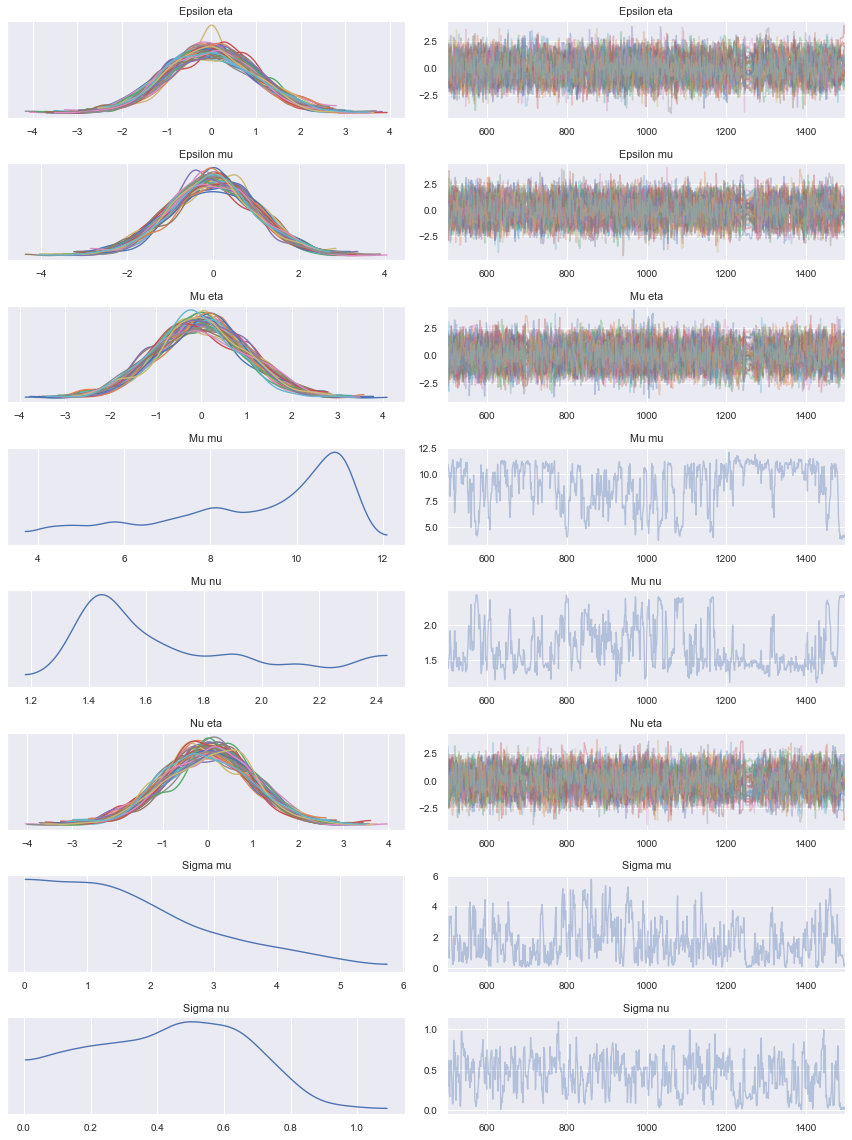

In [60]:
n_samples = 100
log_likelihood = GaussianFilterLogLikelihood(
    observations=data_snapshot2, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * 2 * n_samples + [
    pints.GaussianLogPrior(mean=8, sd=10),
    pints.GaussianLogPrior(mean=0, sd=4),
    pints.HalfCauchyLogPrior(location=1, scale=2),
    pints.HalfCauchyLogPrior(location=1, scale=2)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
gaussian_filter_100_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup=500
az.plot_trace(
    gaussian_filter_100_posterior_samples.sel(draw=slice(warmup, n_iterations)))
plt.tight_layout()

1000 samples

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     12     0.317    4        0:00.2
1     13     0.25     1        0:00.2
2     14     0.25     1        0:00.2
3     21     0.375    4        0:00.3
20    307    0.8      16       0:03.6
40    2184   0.739    90       0:23.0
60    5240   0.763    146      0:54.6
80    5554   0.74     15       0:57.6
100   12381  0.739    325      1:59.0
120   14960  0.737    123      2:21.1
140   15724  0.769    37       2:28.4
160   16170  0.734    21       2:33.9
180   16891  0.755    35       2:41.5
200   18468  0.738    76       2:55.3
220   19340  0.777    42       3:03.7
240   20272  0.746    45       3:14.0
260   20839  0.728    27       3:19.9
280   21813  0.753    47       3:28.8
300   23050  0.741619 59       3:40.8
320   23714  0.769    32       3:46.5
340   24300  0.745    28       3:52.8
360   25327  0.769911 49       4:01.9
380   25960  0.735    31       4:06.8
400   26651  0.749

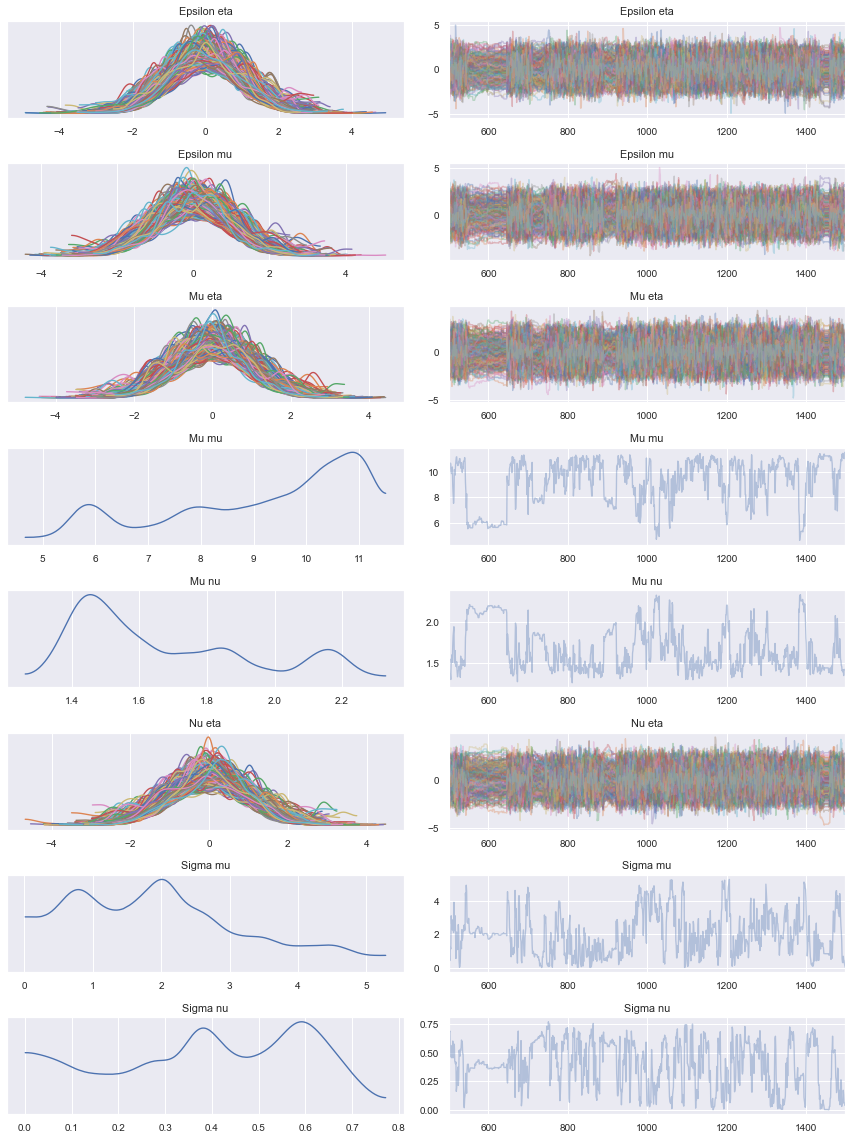

In [62]:
n_samples = 1000
log_likelihood = GaussianFilterLogLikelihood(
    observations=data_snapshot2, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * 2 * n_samples + [
    pints.GaussianLogPrior(mean=8, sd=10),
    pints.GaussianLogPrior(mean=0, sd=4),
    pints.HalfCauchyLogPrior(location=1, scale=2),
    pints.HalfCauchyLogPrior(location=1, scale=2)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
gaussian_filter_1000_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup=500
az.plot_trace(
    gaussian_filter_1000_posterior_samples.sel(
        draw=slice(warmup, n_iterations)))
plt.tight_layout()

### 2. Gaussian KDE filter likelihood

10 samples

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     4      0.25     1        0:00.0
1     5      0.25     1        0:00.0
2     6      0.25     1        0:00.0
3     7      0.25     1        0:00.0
20    1143   0.744    64       0:02.7
40    1867   0.763    35       0:04.1
60    2787   0.755    44       0:05.5
80    3560   0.742    37       0:06.4
100   4201   0.764705 31       0:07.1
120   4648   0.726    22       0:07.7
140   5224   0.754    28       0:08.3
160   6054   0.723    40       0:09.3
180   7160   0.764    53       0:10.6
200   7938   0.733    38       0:11.7
220   9055   0.773    54       0:13.0
240   9681   0.746    30       0:13.7
260   10804  0.715    54       0:15.1
280   11957  0.76     55       0:16.4
300   12584  0.736    30       0:17.2
320   13799  0.777    58       0:18.6
340   15140  0.762    64       0:20.2
360   16043  0.751    43       0:21.5
380   16921  0.765    42       0:23.0
400   17689  0.744

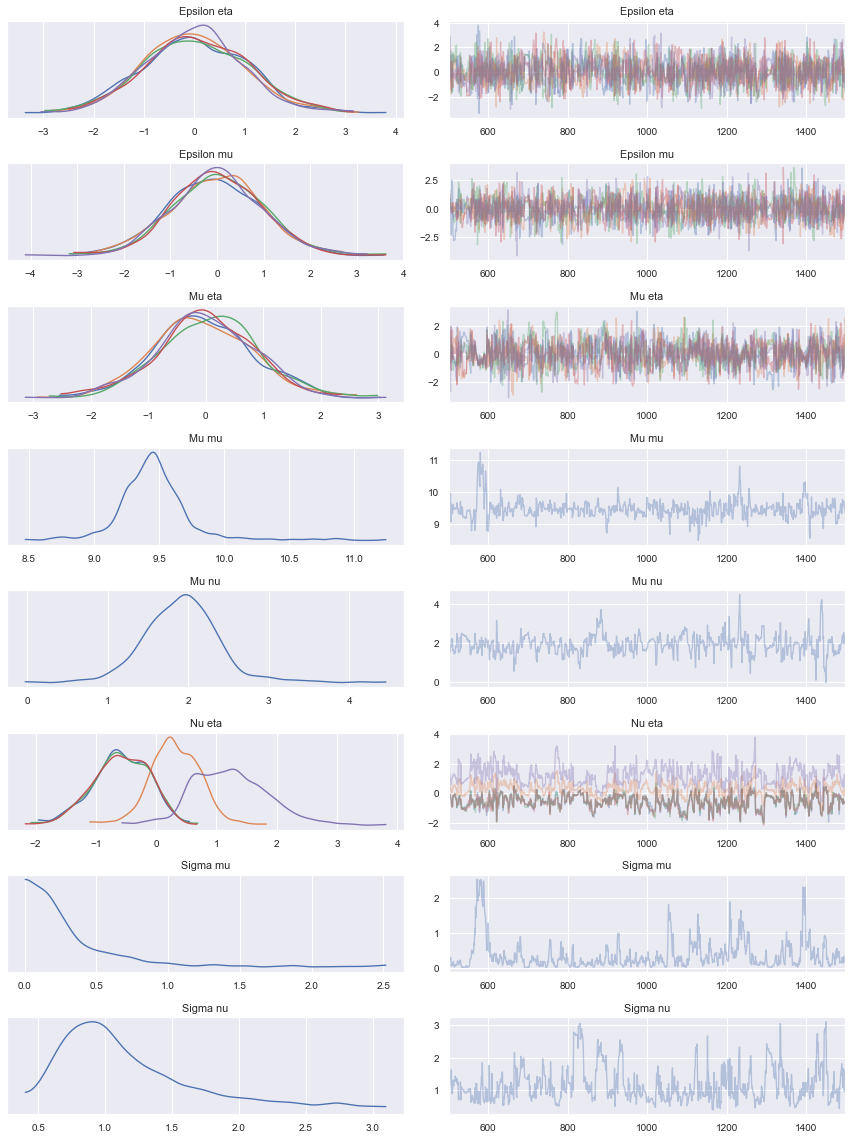

In [81]:
n_samples = 10
log_likelihood = GaussianKDEFilterLogLikelihood(
    observations=data_snapshot2, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * 2 * n_samples + [
    pints.GaussianLogPrior(mean=8, sd=10),
    pints.GaussianLogPrior(mean=0, sd=4),
    pints.HalfCauchyLogPrior(location=1, scale=2),
    pints.HalfCauchyLogPrior(location=1, scale=2)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
gaussian_kde_filter_10_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup=500
az.plot_trace(
    gaussian_kde_filter_10_posterior_samples.sel(
        draw=slice(warmup, n_iterations)))
plt.tight_layout()

100 samples

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     7      0.5      2        0:00.1
1     8      0.25     1        0:00.1
2     9      0.25     1        0:00.1
3     11     0.167    1        0:00.1


/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/pints/_mcmc/_nuts.py:258: RuntimeWarning: overflow encountered in exp
  alpha_dash = min(1.0, np.exp(comparison))
/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/pints/_mcmc/_nuts.py:157: RuntimeWarning: overflow encountered in exp
  p = min(1, np.exp(other_state.n - self.n))


20    8310   0.751    462      0:36.9
40    20837  0.772    597      1:34.5
60    22899  0.749    99       1:44.1
80    23288  0.763    19       1:46.4
100   23695  0.749    20       1:48.9
120   24435  0.726318 36       1:53.0
140   24879  0.746    22       1:55.5
160   25543  0.747    32       1:58.5
180   26251  0.75     34       2:01.5
200   26993  0.749    36       2:04.5
220   27854  0.772    41       2:08.4
240   28425  0.745    28       2:11.5
260   29136  0.687    34       2:14.8
280   30007  0.777    42       2:18.4
300   30859  0.741    41       2:21.8
320   31646  0.75     38       2:25.6
340   32404  0.77     37       2:29.0
360   32991  0.764    28       2:31.6
380   33467  0.743    23       2:33.8
400   34198  0.77     35       2:36.8
420   34748  0.762    27       2:40.7
440   35196  0.748    22       2:43.2
460   35654  0.697    22       2:45.5
480   36240  0.764    28       2:48.8
500   36671  0.752    21       2:50.6
520   37183  0.848    25       2:52.6
540   37797 

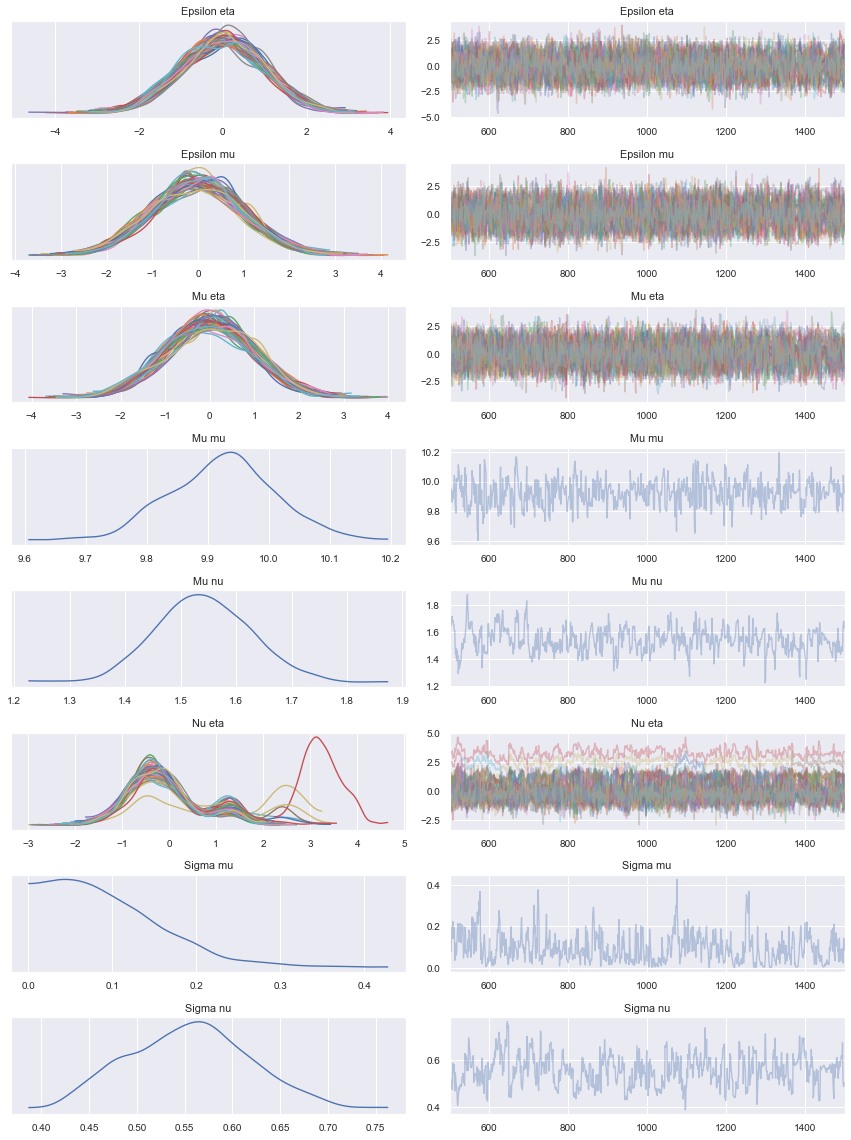

In [83]:
n_samples = 100
log_likelihood = GaussianKDEFilterLogLikelihood(
    observations=data_snapshot2, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * 2 * n_samples + [
    pints.GaussianLogPrior(mean=8, sd=10),
    pints.GaussianLogPrior(mean=0, sd=4),
    pints.HalfCauchyLogPrior(location=1, scale=2),
    pints.HalfCauchyLogPrior(location=1, scale=2)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
gaussian_kde_filter_100_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup=500
az.plot_trace(
    gaussian_kde_filter_100_posterior_samples.sel(
        draw=slice(warmup, n_iterations)))
plt.tight_layout()

## Comparison to analytic posterior

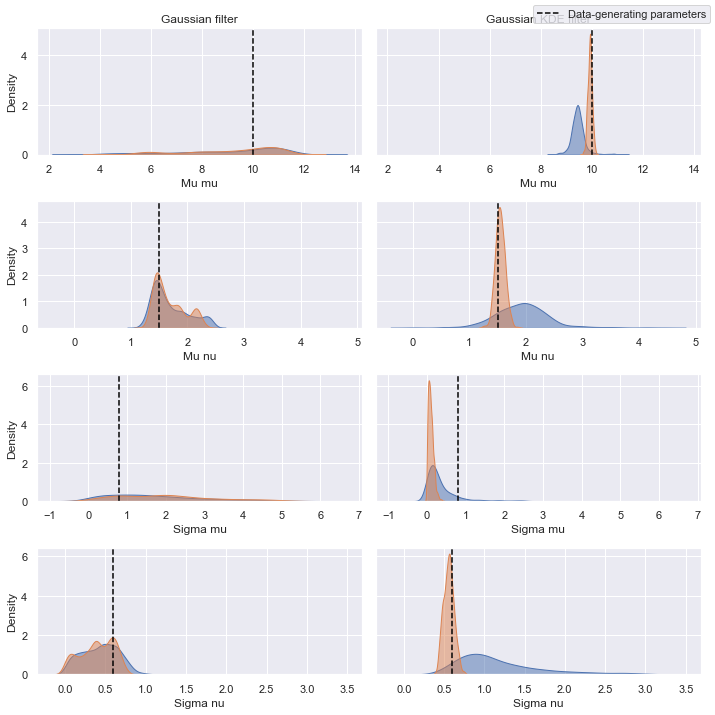

In [84]:
# Create figure
fig, axes = plt.subplots(
    4, 2, figsize=(10, 10), sharey='row', sharex='row')
plt.subplots_adjust(wspace=0.1, hspace=0.3)
# axes[0, 0].set_xlim([0, 2.5])
# axes[1, 0].set_xlim([0, 2])
axes[0, 0].set_xlabel('Mu mu')
axes[0, 1].set_xlabel('Mu mu')
axes[1, 0].set_xlabel('Mu nu')
axes[1, 1].set_xlabel('Mu nu')
axes[2, 0].set_xlabel('Sigma mu')
axes[2, 1].set_xlabel('Sigma mu')
axes[3, 0].set_xlabel('Sigma nu')
axes[3, 1].set_xlabel('Sigma nu')
axes[0, 0].set_title('Gaussian filter')
axes[0, 1].set_title('Gaussian KDE filter')
colors = sns.color_palette()

# Plot Gaussian filter posteriors
warmup = 500
thinning = 1
mu_samples = gaussian_filter_100_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Mu mu'].values[0]
sigma_samples = gaussian_filter_100_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Sigma mu'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[0, 0],
    palette=colors[1], legend=False)
sns.kdeplot(
    x=sigma_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[2, 0],
    palette=colors[0], legend=False)
mu_samples = gaussian_filter_100_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Mu nu'].values[0]
sigma_samples = gaussian_filter_100_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Sigma nu'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[1, 0],
    palette=colors[1], legend=False)
sns.kdeplot(
    x=sigma_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[3, 0],
    palette=colors[0], legend=False)

warmup = 500
thinning = 1
mu_samples = gaussian_filter_1000_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Mu mu'].values[0]
sigma_samples = gaussian_filter_1000_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Sigma mu'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[0, 0],
    palette=colors[1], legend=False)
sns.kdeplot(
    x=sigma_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[2, 0],
    palette=colors[0], legend=False)
mu_samples = gaussian_filter_1000_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Mu nu'].values[0]
sigma_samples = gaussian_filter_1000_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Sigma nu'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[1, 0],
    palette=colors[1], legend=False)
sns.kdeplot(
    x=sigma_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[3, 0],
    palette=colors[0], legend=False)

# Plot Gaussian KDE filter posteriors
warmup = 500
thinning = 1
mu_samples = gaussian_kde_filter_10_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Mu mu'].values[0]
sigma_samples = gaussian_kde_filter_10_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Sigma mu'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[0, 1],
    palette=colors[1], legend=False)
sns.kdeplot(
    x=sigma_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[2, 1],
    palette=colors[0], legend=False)
mu_samples = gaussian_kde_filter_10_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Mu nu'].values[0]
sigma_samples = gaussian_kde_filter_10_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Sigma nu'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[1, 1],
    palette=colors[1], legend=False)
sns.kdeplot(
    x=sigma_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[3, 1],
    palette=colors[0], legend=False)

warmup = 500
thinning = 1
mu_samples = gaussian_kde_filter_100_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Mu mu'].values[0]
sigma_samples = gaussian_kde_filter_100_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Sigma mu'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[0, 1],
    palette=colors[1], legend=False)
sns.kdeplot(
    x=sigma_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[2, 1],
    palette=colors[0], legend=False)
mu_samples = gaussian_kde_filter_100_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Mu nu'].values[0]
sigma_samples = gaussian_kde_filter_100_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Sigma nu'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[1, 1],
    palette=colors[1], legend=False)
sns.kdeplot(
    x=sigma_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[3, 1],
    palette=colors[0], legend=False)

# Overlay true parameters
axes[0, 0].axvline(
    x=true_parameters[0], color='black', linestyle='--',
    label='Data-generating parameters')
axes[1, 0].axvline(
    x=true_parameters[1], color='black', linestyle='--')
axes[2, 0].axvline(
    x=true_parameters[2], color='black', linestyle='--')
axes[3, 0].axvline(
    x=true_parameters[3], color='black', linestyle='--')
axes[0, 1].axvline(
    x=true_parameters[0], color='black', linestyle='--')
axes[1, 1].axvline(
    x=true_parameters[1], color='black', linestyle='--')
axes[2, 1].axvline(
    x=true_parameters[2], color='black', linestyle='--')
axes[3, 1].axvline(
    x=true_parameters[3], color='black', linestyle='--')

fig.legend()
plt.tight_layout()
plt.show()

## Gaussian approximation of t=1 data

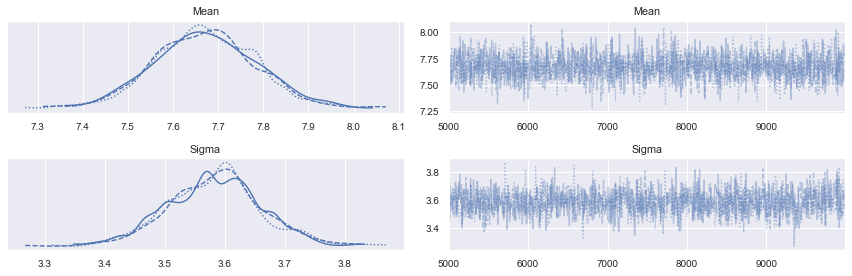

In [86]:
class GaussianLogLikelihood(chi.LogLikelihood):
    def __init__(self, observations):
        self._observations = observations.flatten()

    def __call__(self, parameters):
        # Compute population contribution
        mean, sigma = parameters
        score = np.sum(
            scipy.stats.norm(loc=mean, scale=sigma).logpdf(
                self._observations))

        return score

    def n_parameters(self):
        return 2

    def get_parameter_names(self):
        return ['Mean', 'Sigma']

    def get_id(self):
        return [None, None]


log_likelihood = GaussianLogLikelihood(observations=data_snapshot2)
log_prior = pints.ComposedLogPrior(*[
    pints.UniformLogPrior(-10, 10000),
    pints.UniformLogPrior(0, 1000)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(3)
controller.set_parallel_evaluation(True)
controller.set_transform(pints.LogTransformation(log_posterior.n_parameters()))
n_iterations = 10000
gaussian_posterior = controller.run(
    n_iterations=n_iterations, log_to_screen=False)

warmup = 5000
thinning_ratio = 5
az.plot_trace(
    gaussian_posterior.sel(
        draw=slice(warmup, n_iterations, thinning_ratio)))
plt.tight_layout()

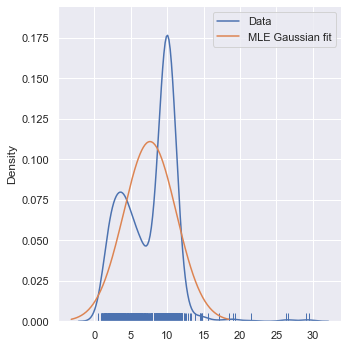

In [87]:
# Sample from Gaussian approximation
mean = 7.65
sigma = 3.6
mus = np.linspace(mean - 3 * sigma, mean + 3 * sigma, num=200)
true_pdf = scipy.stats.norm(mean, sigma).pdf(mus)

# Visualse approximation and data
ax = sns.displot(data_snapshot2, kind='kde', rug=True, label='Data')
plt.plot(mus, true_pdf, color=colors[1], label='MLE Gaussian fit')

plt.legend()
plt.show()

# Infer from both time points

In [ ]:
class GaussianFilterLogLikelihood(chi.LogLikelihood):
    def __init__(self, observations, n_samples=10):
        self._observations = observations
        self._n_half_samples = n_samples // 2
        self._normal = chi.GaussianErrorModel()

    def __call__(self, parameters):
        # Eta are inter-individual fluctuations and epsilon are measurement
        # fluctuations
        eta_mu = np.array(parameters[:self._n_half_samples])
        eta_nu = np.array(
            parameters[self._n_half_samples:2*self._n_half_samples])
        epsilon = np.array(
            parameters[2*self._n_half_samples:6*self._n_half_samples]).reshape(
                (2, 2*self._n_half_samples))
        mu_mu, mu_nu, sigma_mu, sigma_nu = parameters[
            6*self._n_half_samples:6*self._n_half_samples+4]
        sigma = 0.1

        # Compute measurements
        times = np.array([0.5, 1])[:, np.newaxis]
        normal_samples = (mu_mu + eta_mu * sigma_mu)[np.newaxis, :] * times
        lognormal_samples = \
            np.exp((mu_nu + eta_nu * sigma_nu)[np.newaxis, :] * times)
        measurements = \
            np.hstack([normal_samples, lognormal_samples]) \
            + sigma * epsilon

        # Estimate population mean and population std from samples
        pop_mu_hat = np.mean(measurements, axis=1)
        pop_sigma_hat = np.std(measurements, ddof=1, axis=1)

        # Compute log-likelihood
        score = 0
        for idt, obs_at_t in enumerate(self._observations):
            score += \
                np.sum(scipy.stats.norm(
                    loc=pop_mu_hat[idt], scale=pop_sigma_hat[idt]
                    ).logpdf(obs_at_t))

        return score

    def evaluateS1(self, parameters):
        # Eta are inter-individual fluctuations and epsilon are measurement
        # fluctuations
        eta_mu = np.array(parameters[:self._n_half_samples])
        eta_nu = np.array(
            parameters[self._n_half_samples:2*self._n_half_samples])
        epsilon = np.array(
            parameters[2*self._n_half_samples:6*self._n_half_samples]).reshape(
                (2, 2*self._n_half_samples))
        mu_mu, mu_nu, sigma_mu, sigma_nu = parameters[
            6*self._n_half_samples:6*self._n_half_samples+4]
        sigma = 0.1

        # Compute measurements
        times = np.array([0.5, 1])[:, np.newaxis]
        normal_samples = \
            (mu_mu + eta_mu * sigma_mu)[np.newaxis, :] * times
        lognormal_samples = \
            np.exp((mu_nu + eta_nu * sigma_nu)[np.newaxis, :]
            * times)
        measurements = \
            np.hstack([normal_samples, lognormal_samples]) \
            + sigma * epsilon

        # Estimate population mean and population std from samples
        pop_mu_hat = np.mean(measurements, axis=1)
        pop_sigma_hat = np.std(measurements, ddof=1, axis=1)

        # Compute sensitivities of pop_mu and pop_sigma to parameters
        dpop_mu_hat_deta_mu = \
            times[:, 0] * sigma_mu / self._n_half_samples / 2
        dpop_mu_hat_deta_nu = \
            times[:, 0] * sigma_nu * lognormal_samples / self._n_half_samples / 2
        dpop_mu_hat_depsilon = sigma / self._n_half_samples / 2
        dpop_mu_hat_dmu_mu = times[:, 0] / 2
        dpop_mu_hat_dmu_nu = \
            np.mean(times * lognormal_samples, axis=1) / 2
        dpop_mu_hat_dsigma_mu = \
            np.mean(times * eta_mu[np.newaxis, :], axis=1) / 2
        dpop_mu_hat_dsigma_nu = \
            np.mean(times * lognormal_samples * eta_nu[np.newaxis, :]) / 2
        dpop_sigma_hat_deta_mu = \
            times * sigma_mu * (measurements[:, :self._n_half_samples]
            - pop_mu_hat[:, np.newaxis]) / (2 * self._n_half_samples - 1) \
            / pop_sigma_hat[:, np.newaxis]
        dpop_sigma_hat_deta_nu = \
            times * sigma_nu * lognormal_samples \
            * (measurements[:, self._n_half_samples:]
            - pop_mu_hat[:, np.newaxis]) / (2 * self._n_half_samples - 1) \
            / pop_sigma_hat[:, np.newaxis]
        dpop_sigma_hat_depsilon = \
            times * sigma * (measurements - pop_mu_hat[:, np.newaxis]) / \
            (2 * self._n_half_samples - 1) / pop_sigma_hat[:, np.newaxis]
        dmeas_dmu_mu = np.zeros(self._n_half_samples * 2)
        dmeas_dmu_mu[:self._n_half_samples] = 1
        dpop_sigma_hat_dmu_mu = np.sum(
            (dmeas_dmu_mu - dpop_mu_hat_dmu_mu) *
            (measurements - pop_mu_hat)
            / (2 * self._n_half_samples - 1) / pop_sigma_hat)
        dmeas_dmu_nu = np.zeros(self._n_half_samples * 2)
        dmeas_dmu_nu[self._n_half_samples:] = lognormal_samples
        dpop_sigma_hat_dmu_nu = np.sum(
            (dmeas_dmu_nu - dpop_mu_hat_dmu_nu) *
            (measurements - pop_mu_hat)
            / (2 * self._n_half_samples - 1) / pop_sigma_hat)
        dmeas_dsigma_mu = np.zeros(self._n_half_samples * 2)
        dmeas_dsigma_mu[:self._n_half_samples] = eta_mu
        dpop_sigma_hat_dsigma_mu = np.sum(
            (dmeas_dsigma_mu - dpop_mu_hat_dsigma_mu) *
            (measurements - pop_mu_hat)
            / (2 * self._n_half_samples - 1) / pop_sigma_hat)
        dmeas_dsigma_nu = np.zeros(self._n_half_samples * 2)
        dmeas_dsigma_nu[self._n_half_samples:] = lognormal_samples * eta_nu
        dpop_sigma_hat_dsigma_nu = np.sum(
            (dmeas_dsigma_nu - dpop_mu_hat_dsigma_nu) *
            (measurements - pop_mu_hat)
            / (2 * self._n_half_samples - 1) / pop_sigma_hat)

        # Estimate likelihood with Gaussian KDE and compute associated
        # sensitivities
        n_obs = len(self._observations)
        model_sensitivities = np.broadcast_to(np.hstack([
            dpop_mu_hat_deta_mu,  # Only one copy - all the same
            dpop_mu_hat_deta_nu,
            dpop_mu_hat_depsilon,  # Only one copy - all the same
            dpop_mu_hat_dmu_mu,
            dpop_mu_hat_dmu_nu,
            dpop_mu_hat_dsigma_mu,
            dpop_mu_hat_dsigma_nu]),
            shape=(n_obs, self._n_half_samples + 6))
        score, sens = self._normal.compute_sensitivities(
            parameters=[pop_sigma_hat],
            model_output=np.array([pop_mu_hat] * n_obs),
            model_sensitivities=model_sensitivities,
            observations=self._observations)

        # Compute final sensitivities
        # dp/deta =
        #   dp/dpop_mu_hat * dpop_mu_hat/deta +
        #   dp/dpop_sigma_hat * dpop_sigma_hat/deta
        # dp/depsilon =
        #   dp/dpop_mu_hat * dpop_mu_hat/depsilon +
        #   dp/dpop_sigma_hat * dpop_sigma_hat/depsilon
        # dp/dpop_mu =
        #   dp/dpop_mu_hat * dpop_mu_hat/dpop_mu +
        #   dp/dpop_sigma_hat * dpop_sigma_hat/dpop_mu
        # dp/dpop_sigma =
        #   dp/dpop_mu_hat * dpop_mu_hat/dpop_sigma +
        #   dp/dpop_sigma_hat * dpop_sigma_hat/dpop_sigma
        sensitivities = np.zeros(shape=self.n_parameters())
        sensitivities[:self._n_half_samples] = \
            sens[0] + sens[self._n_half_samples+6] * dpop_sigma_hat_deta_mu
        sensitivities[self._n_half_samples:2*self._n_half_samples] = \
            sens[1:self._n_half_samples+1] \
            + sens[self._n_half_samples+6] * dpop_sigma_hat_deta_nu
        sensitivities[2*self._n_half_samples:4*self._n_half_samples] = \
            sens[self._n_half_samples+1] \
            + sens[self._n_half_samples+6] * dpop_sigma_hat_depsilon
        sensitivities[4*self._n_half_samples] = \
            sens[self._n_half_samples+2] \
            + sens[self._n_half_samples+6] * dpop_sigma_hat_dmu_mu
        sensitivities[4*self._n_half_samples+1] = \
            sens[self._n_half_samples+3] \
            + sens[self._n_half_samples+6] * dpop_sigma_hat_dmu_nu
        sensitivities[4*self._n_half_samples+2] = \
            sens[self._n_half_samples+4] \
            + sens[self._n_half_samples+6] * dpop_sigma_hat_dsigma_mu
        sensitivities[4*self._n_half_samples+3] = \
            sens[self._n_half_samples+5] \
            + sens[self._n_half_samples+6] * dpop_sigma_hat_dsigma_nu

        return score, sensitivities

    def n_parameters(self):
        return 4 * self._n_half_samples + 4

    def get_parameter_names(self):
        return [
            'Mu eta' for _ in range(self._n_half_samples)] + [
            'Nu eta' for _ in range(self._n_half_samples)] + [
            'Epsilon mu' for _ in range(self._n_half_samples)] + [
            'Epsilon eta' for _ in range(self._n_half_samples)] + [
            'Mu mu', 'Mu nu', 'Sigma mu', 'Sigma nu']

    def get_id(self):
        return ['ID %d' % _id for _id in range(self._n_half_samples)] * 4 + [
            None] * 4